# Overview
This repo aims to classify the tumor using Vision Transformer (ViT)
- [Reference code](https://www.kaggle.com/code/ebrahimelgazar/vision-transformer-vit-keras-pretrained-models/notebook) from kaggle
- Original paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)
- [Dataset](https://www.kaggle.com/datasets/denizkavi1/brain-tumor) from kaggle
- 3 classes:
  - Meningioma  (708 slices)
  - Glioma (1426 slices)
  - Pituitary tumor (930 slices)
- MLP head is replaced with BatchNorm-->3*Dense Layers

![image](https://github.com/guyuxuan9/Transformer-from-scratch/assets/58468284/48ef9a0c-72bf-4aa4-b9be-9ec3961f139a)

- Each image is reshaped to 224*224.
- Transfer learning is used on the pre-trained ViT B16 model. The patch size is 16*16. Hence, there are (224/16) * (224/16) = 14 * 14 = 196 patches. Each patch ($\mathbf{x}_p^i$) is passed to a linear projection layer (multiplied by a matrix $E$), and after which each patch becomes a 1D vector of dimension $D$. A token $[CLS]$ is pre-pend to the vectors to indicate this is a classification problem. This sequence of vector is then passed to the transformer encoder.


- $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$ is composed of $N$ patches, where ($P$,$P$) is the resolution of each image patch and $C$ is the # of channels

- $E \in \mathbb{R}^{(P^2 \cdot C) \times D}$, where $D$ is the latent vector size.

- The input to the transformer is a vector $z_0 = \begin{bmatrix} x_{\text{class}} & x^1_{\text{p}}E & x^2_{\text{p}}E & \ldots & x^N_{\text{p}}E \end{bmatrix} + E_{\text{pos}}, \quad E \in \mathbb{R}^{(P^2 \cdot C) \times D}, \quad E_{\text{pos}} \in \mathbb{R}^{(N+1) \times D}$






# Import some libraries

In [2]:
!pip install kaggle
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d denizkavi1/brain-tumor/
!unzip -q brain-tumor.zip -d brain-tumor

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 698M/700M [00:31<00:00, 24.0MB/s]
100% 700M/700M [00:31<00:00, 23.4MB/s]


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

import warnings
warnings.filterwarnings("ignore")

TensorFlow Version 2.15.0


# Data preprocessing

In [4]:
image_size = 224 # original image shape is (512, 512, 3), can be verified by image = cv2.imread(...), image.shape
batch_size = 16
n_classes = 3
EPOCHS = 30

train_path = '/content/brain-tumor'

classes = {1 : "Meningioma", # 708 slices
           2 : "Glioma", # 1426 slices
           3 : "Pituitary Tumor"} # 930 slices

In [5]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32) # 0-dimentional tensor: a scalar
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if p_spatial > .75:
        image = tf.image.transpose(image)

    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º

    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)

    return image

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True, # Set each sample mean to 0
                                                          samplewise_std_normalization = True, # Divide each input by its std
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)
# set as training data

train_gen  = datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = True,
    class_mode='categorical',
    subset='training')

# same directory as training data

valid_gen  = datagen.flow_from_directory(
    train_path ,
    target_size=(image_size, image_size),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode='categorical',
    subset='validation')

Found 2452 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


# Plot some normalised images

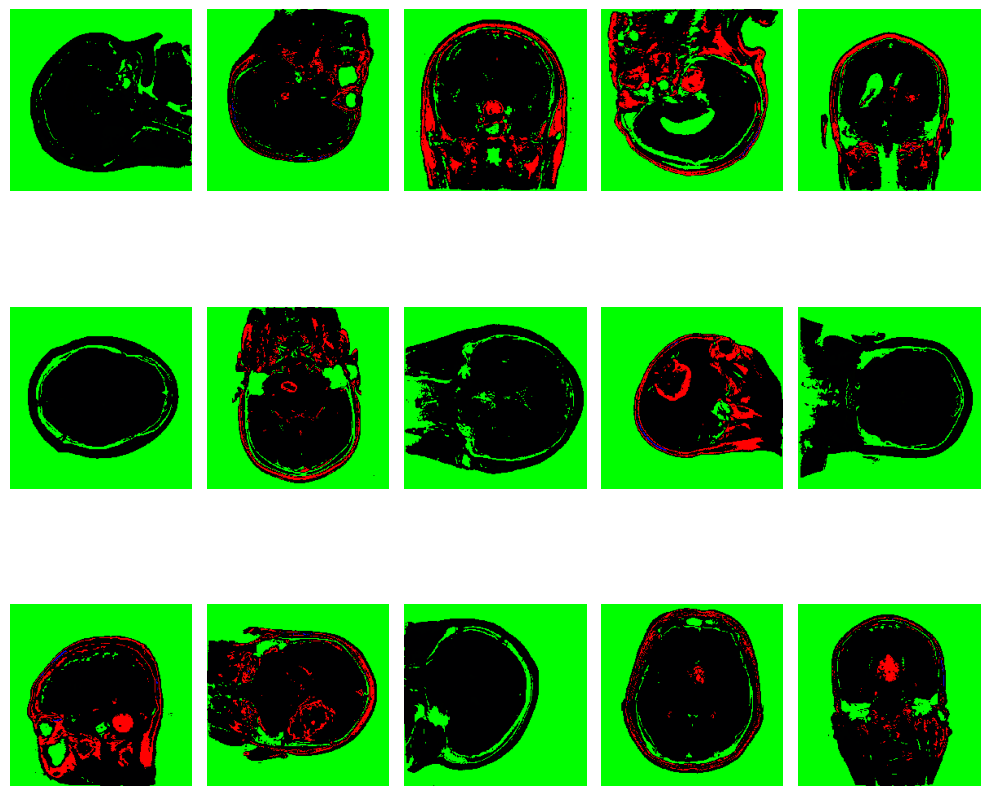

In [7]:
warnings.filterwarnings("ignore")

images = [train_gen[6][0][i] for i in range(16)]
# train_gen[0] -- train_gen[153]: 0th to 153th batch (2452 = 153*16 + 4)
# train_gen[batch_index][0]: image,  train_gen[batch_index][1]: label
# train_gen[batch_index][0][i]: image of ith batch, shape = (16, 224, 224, 3)

fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(image_size, image_size, 3).astype("uint8"))
    ax.axis('off')

plt.tight_layout()
plt.show()
# The images below look a bit different from the original image since it has been normalised

In [8]:
!pip install vit_keras

In [10]:
!pip install tensorflow-addons==0.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.5 MB/s eta 0:00:00


# Visualise the patches
In this case, the patch size is set to 7 for visualisation purposes.

In [12]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0] # =1 in the following code
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        ) # shape = (1, 32, 32, 147), 224/7 = 32, 7*7*3 channels = 147
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims]) # given batch_size, patch_dims, fill the middle dimension automatically
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


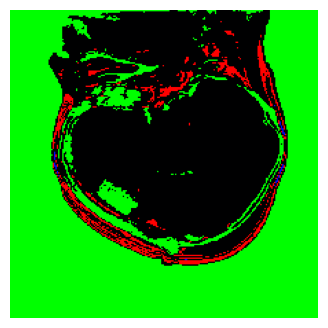

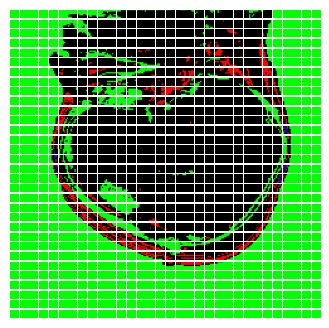

In [13]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2   # 224/7 = 32

x = train_gen.next() # next batch
image = x[0][0] # x[0].shape = (16, 224, 224, 3)

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
) # shape = (1, 224, 224, 3)

patches = Patches(patch_size)(resized_image) # shape = (1, 1024, 147)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3)) # (147, ) --> (7, 7, 3)
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

# Build & Train the model

In [11]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size, # 224
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

347502902/347502902 [==============================] - 1s 0us/step


In [14]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tf.keras.activations.gelu), # Gaussian Error Linear Unit
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tf.keras.activations.gelu),
        tf.keras.layers.Dense(32, activation = tf.keras.activations.gelu),
        tf.keras.layers.Dense(3, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

In [16]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size



early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30
153/153 [==============================] - 194s 1s/step - loss: 0.6120 - accuracy: 0.9204 - val_loss: 0.7725 - val_accuracy: 0.8635
Epoch 2/30
153/153 [==============================] - 153s 1s/step - loss: 0.6092 - accuracy: 0.9183 - val_loss: 0.8559 - val_accuracy: 0.7829
Epoch 3/30
153/153 [==============================] - 153s 1s/step - loss: 0.5801 - accuracy: 0.9392 - val_loss: 0.6309 - val_accuracy: 0.9013
Epoch 4/30
153/153 [==============================] - 154s 1s/step - loss: 0.5725 - accuracy: 0.9388 - val_loss: 0.6279 - val_accuracy: 0.8947
Epoch 5/30
153/153 [==============================] - 152s 996ms/step - loss: 0.5645 - accuracy: 0.9417 - val_loss: 0.6954 - val_accuracy: 0.8701
Epoch 6/30
153/153 [==============================] - 152s 993ms/step - loss: 0.5460 - accuracy: 0.9598 - val_loss: 0.6076 - val_accuracy: 0.9112
Epoch 7/30
153/153 [==============================] - 152s 991ms/step - loss: 0.5579 - accuracy: 0.9458 - val_loss: 0.6101 - val_accurac

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'Input error: exclusive=True: more than 1 conditions (?, ?, ?) evaluated as True:'
True, True, False
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 385, in _get_batches_of_transformed_samples
    x = self.image_data_generator.standardize(x)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 1850, in standardize
    x = self.preprocessing_function(x)

  File "<ipython-input-5-047d8a8a13d9>", line 19, in data_augment
    image = tf.image.rot90(image, k = 2) # rotate 180º

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/control_flow_assert.py", line 102, in Assert
    raise errors.InvalidArgumentError(

tensorflow.python.framework.errors_impl.InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'Input error: exclusive=True: more than 1 conditions (?, ?, ?) evaluated as True:'
True, True, False


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[categorical_crossentropy/Shape/_6]]
  (1) UNKNOWN:  InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'Input error: exclusive=True: more than 1 conditions (?, ?, ?) evaluated as True:'
True, True, False
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 385, in _get_batches_of_transformed_samples
    x = self.image_data_generator.standardize(x)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 1850, in standardize
    x = self.preprocessing_function(x)

  File "<ipython-input-5-047d8a8a13d9>", line 19, in data_augment
    image = tf.image.rot90(image, k = 2) # rotate 180º

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/control_flow_assert.py", line 102, in Assert
    raise errors.InvalidArgumentError(

tensorflow.python.framework.errors_impl.InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'Input error: exclusive=True: more than 1 conditions (?, ?, ?) evaluated as True:'
True, True, False


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_1400369]

# Evaluate the model


## Confusion matrix

39/39 [==============================] - 17s 423ms/step
              precision    recall  f1-score   support

           0       0.92      0.85      0.89       141
           1       0.94      0.95      0.94       285
           2       0.93      0.97      0.95       186

    accuracy                           0.93       612
   macro avg       0.93      0.92      0.93       612
weighted avg       0.93      0.93      0.93       612



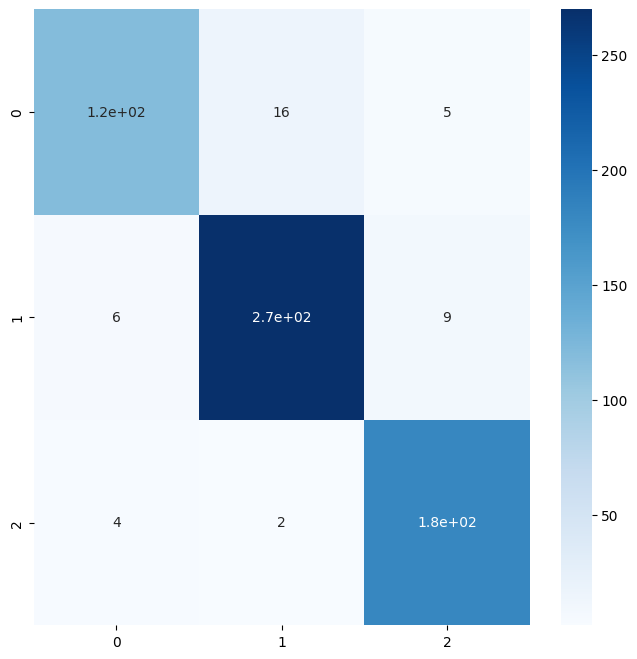

In [70]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
# x axis: ground truth; y axis: predicted values

plt.figure(figsize = (8, 8))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

## Prediction vs. Ground truth

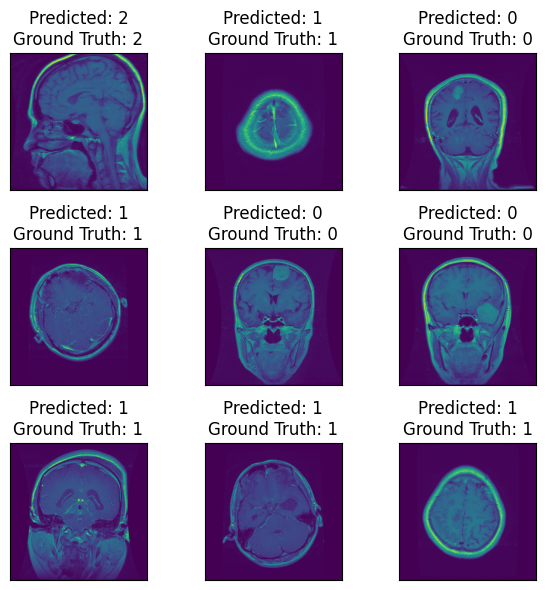

In [44]:
import numpy as np
import matplotlib.pyplot as plt

n_plots = 9
ground_truth_labels = valid_gen.classes
selected_samples = np.random.choice(valid_gen.n, size=n_plots, replace=False)

# Draw 9 figures and print the predicted label and ground truth label
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flatten()):
    # Plot an image
    image_index = selected_samples[i]
    img = plt.imread("/content/brain-tumor/" + valid_gen.filenames[image_index])
    ax.imshow(img)

    # Get predicted and ground truth labels for the current sample
    predicted_label = predicted_classes[image_index]
    ground_truth_label = ground_truth_labels[image_index]

    # Set title with predicted and ground truth labels
    ax.set_title(f'Predicted: {predicted_label}\nGround Truth: {ground_truth_label}')

    # Remove x and y axis labels for clarity
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [62]:
probability = model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1)

39/39 [==============================] - 17s 429ms/step


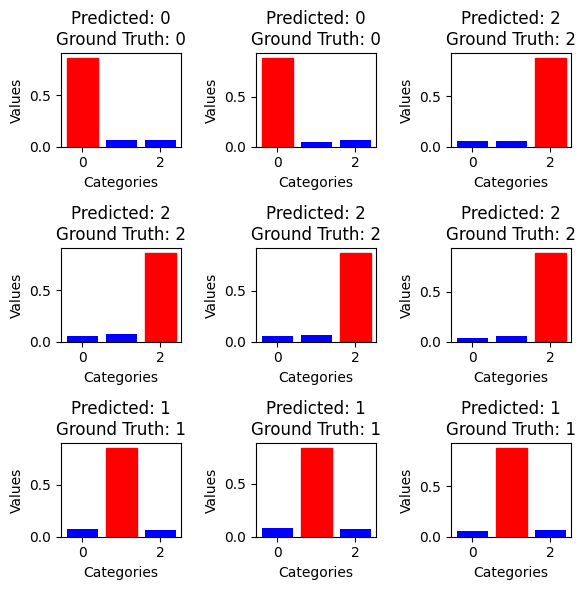

In [63]:
import matplotlib.pyplot as plt
import numpy as np


selected_samples = np.random.choice(valid_gen.n, size=9, replace=False)
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flatten()):
    # Select the sample index from selected_samples
    sample_index = selected_samples[i]

    # Get the data for the selected sample
    data = probability[sample_index,:]
    ground_truth_label = ground_truth_labels[sample_index]
    predicted_label = np.argmax(data)

    # Create a bar chart for the selected sample
    bars = ax.bar(range(3), data, color='blue')
    max_index = np.argmax(data)
    bars[max_index].set_color('red')
    # Set labels and title for each subplot
    ax.set_xlabel('Categories')
    ax.set_ylabel('Values')
    ax.set_title(f'Predicted: {predicted_label}\nGround Truth: {ground_truth_label}')

plt.tight_layout()
plt.show()

## Misclassified samples

In [66]:
# find all misclassified samples
misclassified_indices = []

for i in range(valid_gen.n):
    predicted_label = np.argmax(probability[i])
    ground_truth_label = ground_truth_labels[i]

    # Check if the prediction is correct or not
    if predicted_label != ground_truth_label:
        misclassified_indices.append(i)

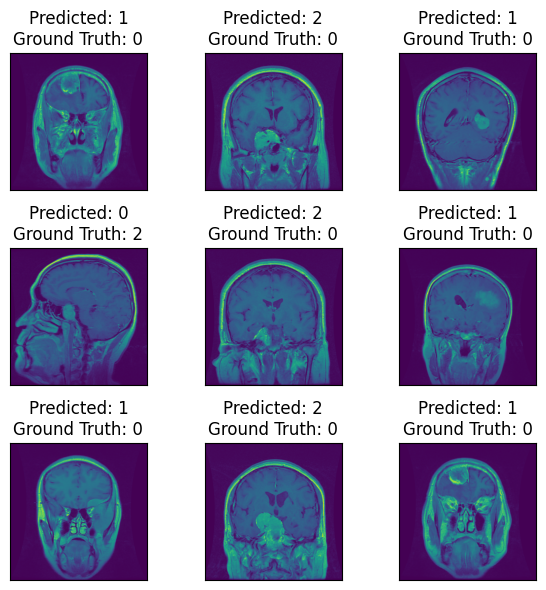

In [69]:
# Plot the misclassified samples
n_plots = 9
ground_truth_labels = valid_gen.classes
selected_samples = np.random.choice(misclassified_indices, size=n_plots, replace=False)

# Draw 9 figures and print the predicted label and ground truth label
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flatten()):
    # Plot an image
    image_index = selected_samples[i]
    img = plt.imread("/content/brain-tumor/" + valid_gen.filenames[image_index])
    ax.imshow(img)

    # Get predicted and ground truth labels for the current sample
    predicted_label = np.argmax(probability[image_index])
    ground_truth_label = ground_truth_labels[image_index]

    # Set title with predicted and ground truth labels
    ax.set_title(f'Predicted: {predicted_label}\nGround Truth: {ground_truth_label}')

    # Remove x and y axis labels for clarity
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [71]:
model.save('/content/drive/MyDrive/ViT_tumor_classification.h5')